In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('test_data.csv')
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


**Выведем график зависимости количества рекламных событий от даты:**

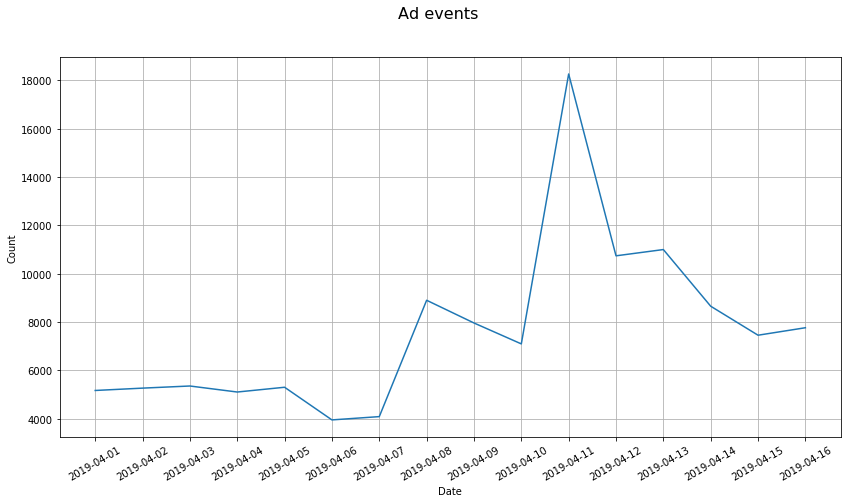

In [3]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))
fig.suptitle('Ad events', fontsize=16) 
plt.plot(df.groupby('date').event.count())
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid();

**Добавим колонку с временем суток:**

In [4]:
df['daytime'] = pd.to_datetime(df.time, unit='s').apply(lambda x: x.hour + x.minute / 100)

In [5]:
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,daytime
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,17.22
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,21.10
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,8.16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,15.07
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,7.11


**Рассмотрим, как в течение суток меняется количество рекламных событий:**

In [6]:
spike_day = df.query("date == '2019-04-11'") # день, когда наблюдался скачок
no_spike = df.query("date != '2019-04-11'") # остальные дни
day_before = df.query("date == '2019-04-10'") # день перед скачком
day_after = df.query("date == '2019-04-12'") # день после скачка

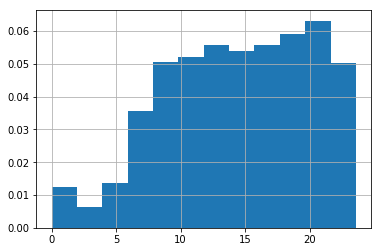

In [7]:
no_spike.daytime.hist(bins=12, density='normed');

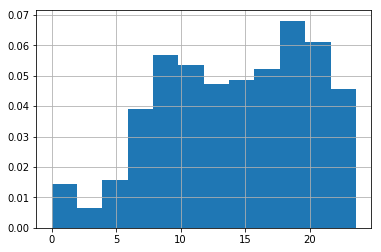

In [8]:
day_before.daytime.hist(bins=12, density='normed');

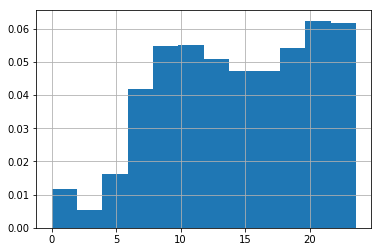

In [9]:
day_after.daytime.hist(bins=12, density='normed');

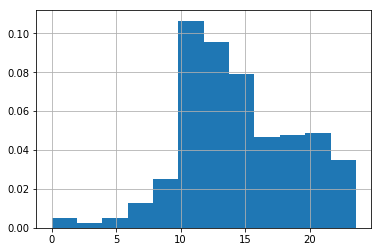

In [10]:
spike_day.daytime.hist(bins=12, density='normed');

**В день скачка можем наблюдать, что пик количества рекламных событий приходится на промежуток с 10 до 15 часов**

**Проверим, не связано ли это с активностью ботов, кликающих на рекламу:**

In [11]:
no_spike.event.value_counts(normalize=True)

view      0.692213
click     0.258364
report    0.049423
Name: event, dtype: float64

In [12]:
spike_day.event.value_counts(normalize=True)

view      0.881593
click     0.099184
report    0.019223
Name: event, dtype: float64

**Оказывается, наоборот, доля кликов в день скачка еще ниже, чем в другие дни**

**Сравним показания в колонках датафрейма в день скачка и другие дни:**

In [13]:
feature_list = list(df)[1:-2]
feature_list

['event',
 'ad_cost_type',
 'has_video',
 'agency_union_id',
 'client_union_id',
 'campaign_union_id',
 'ad_id',
 'platform']

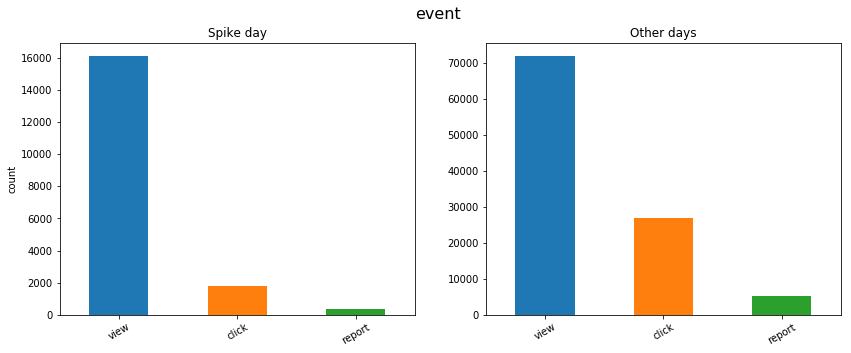

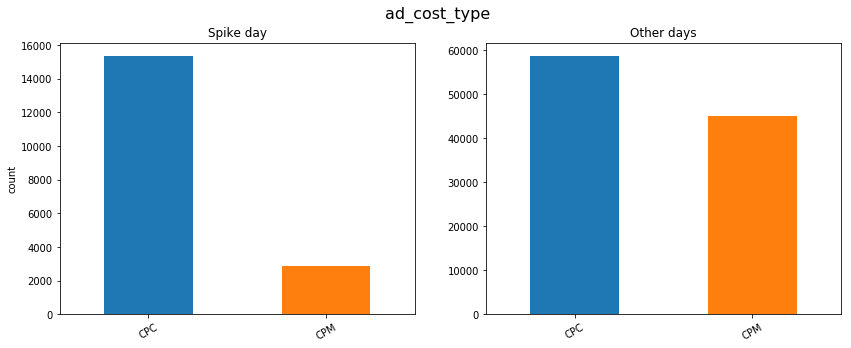

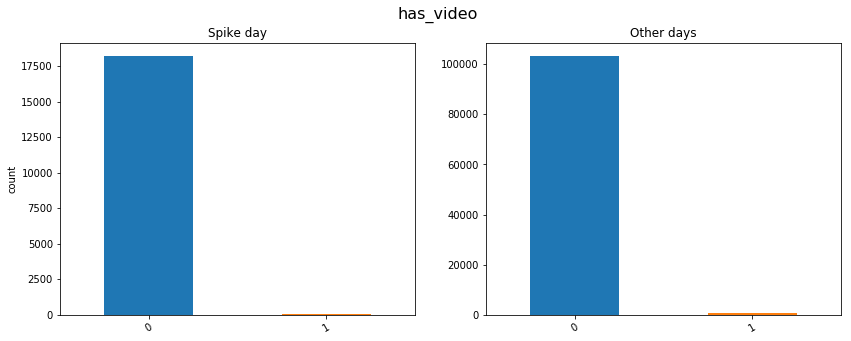

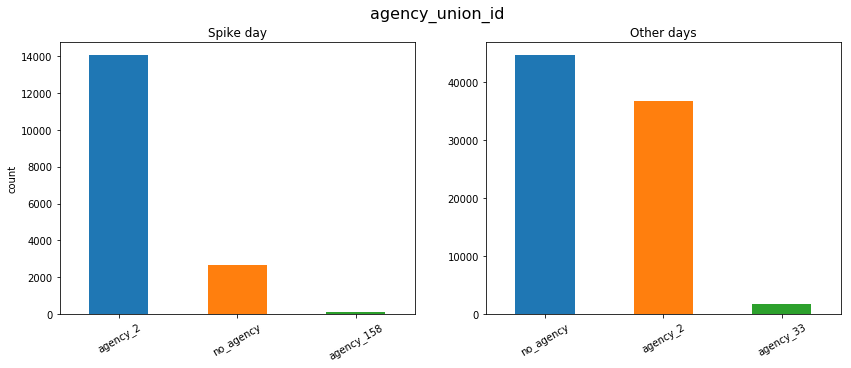

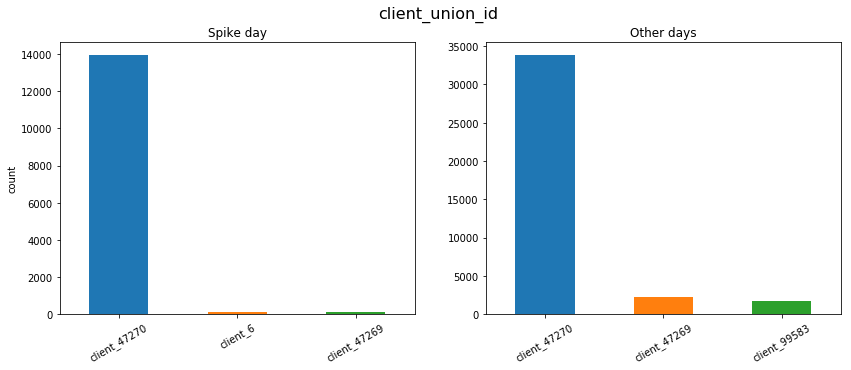

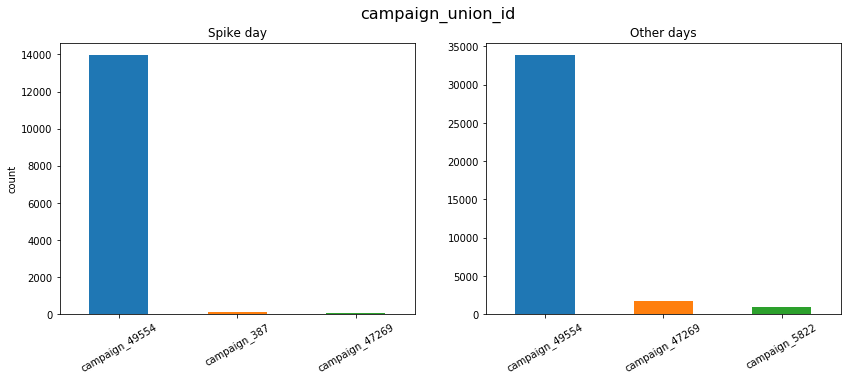

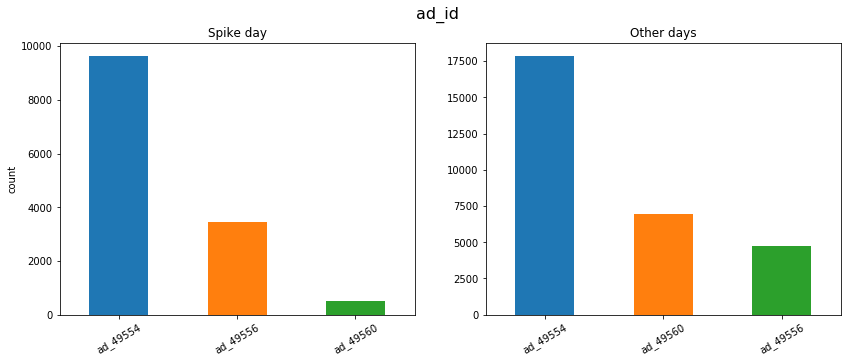

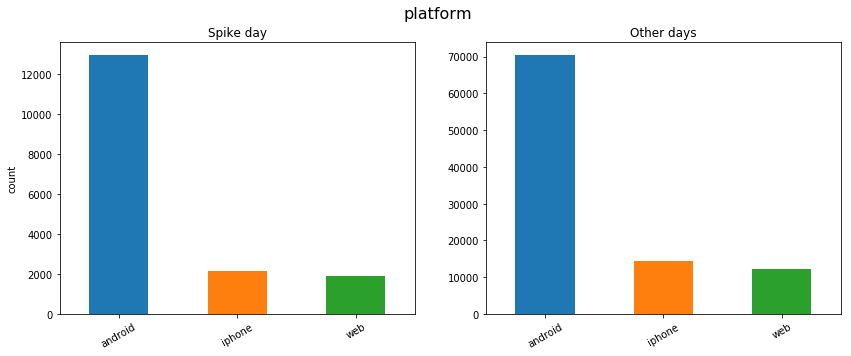

In [14]:
for column_name in feature_list: 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5)) 
    fig.suptitle(column_name,fontsize=16) 
    spike_day[column_name].value_counts()[:3].plot(kind='bar', ax=ax1)
    ax1.set_title('Spike day')
    ax1.set_ylabel('count')
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(30)
    no_spike[column_name].value_counts()[:3].plot(kind='bar', ax=ax2)
    ax2.set_title('Other days') 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(30)

**Скачок вызван большим количеством событий, связанных с рекламной кампанией `campaign_49554` от клиента `client_47270`**

In [15]:
spike_only_suspicious_ad = spike_day.query("campaign_union_id == 'campaign_49554'")
spike_no_suspicious_ad = spike_day.query("campaign_union_id != 'campaign_49554'")

**Проверим, не было ли продублировано одно и то же событие в датафрейме. Для этого сравним общее и уникальное количество значений в колонке `time`**

In [16]:
spike_only_suspicious_ad.time.count()

13941

In [17]:
spike_only_suspicious_ad.time.nunique()

12007

**Нет, значения соизмеримы**

**Убедимся, что именно из-за этой рекламной компании наблюдается скачок с 10 до 15 часов:**

Suspicious ad campaign daytime std: 4.04


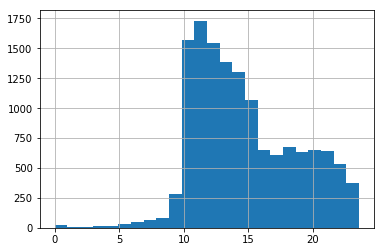

In [18]:
print('Suspicious ad campaign daytime std: {:2.2f}'.format(spike_only_suspicious_ad.daytime.std()))
spike_only_suspicious_ad.daytime.hist(bins=24);

No suspicious ad campaign daytime std: 5.78


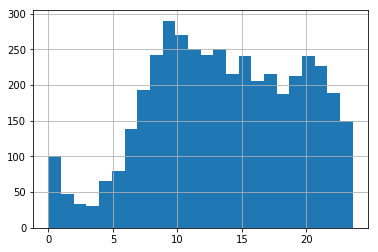

In [19]:
print('No suspicious ad campaign daytime std: {:2.2f}'.format(spike_no_suspicious_ad.daytime.std()))
spike_no_suspicious_ad.daytime.hist(bins=24);

**Действительно, без этой кампании распределение количества рекламных событий в течение суток по характеру похоже на распределения в другие дни.**

**Рассмотрим, на каких платформах размещалась подозрительная кампания и как часто ее кликали/отправляли жалобу:**

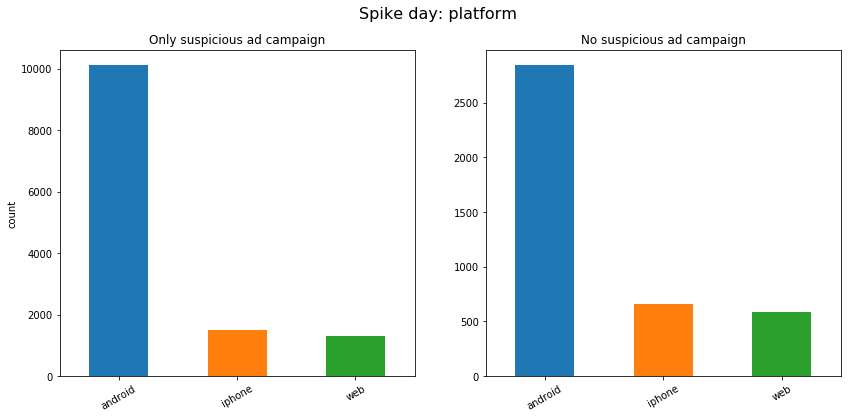

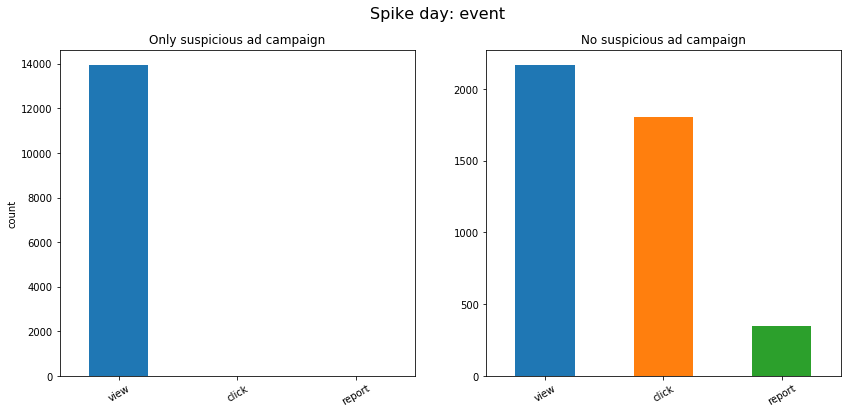

In [20]:
for column_name in ['platform', 'event']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    fig.suptitle('Spike day: ' + column_name, fontsize=16) 
    spike_only_suspicious_ad[column_name].value_counts()[:3].plot(kind='bar', ax=ax1)
    ax1.set_title('Only suspicious ad campaign')
    ax1.set_ylabel('count')
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(30)
    spike_no_suspicious_ad[column_name].value_counts()[:3].plot(kind='bar', ax=ax2)
    ax2.set_title('No suspicious ad campaign') 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(30)

**Заметим, что клики и жалобы практически отсутствуют. Нормально ли это?**

In [21]:
spike_only_suspicious_ad.event.value_counts(normalize=True)

view      0.999283
click     0.000502
report    0.000215
Name: event, dtype: float64

**Построим датафрейм, в котором расположим рекламные кампании в порядке их распространнености (чем больше событий с рекламной кампанией, тем она выше):**

In [22]:
ad_campaign_prevalence = df['campaign_union_id'].value_counts().to_frame().rename(columns={'campaign_union_id':'count'})
ad_campaign_prevalence[:5]

,count
campaign_49554,47739
campaign_47269,1867
campaign_5822,1012
campaign_387,794
campaign_1181,698


**Наша подозрительная реклама на первом месте. Проверим, как часто кликают на вторую:**

In [23]:
df.query("campaign_union_id == @ad_campaign_prevalence.index[1]").event.value_counts(normalize=True)

view     0.999464
click    0.000536
Name: event, dtype: float64

**Видимо, это норма для распространненых реклам - возможно, пользователь начинает относиться к ним как к спаму и игнорирует.**

**Пик просмотров 11 апреля мог быть вызван, например, выпуском новой продукции клиентом `client_47270`. Со временем количество событий, связанных с рассматриваемой рекламной кампанией, постепенно уменьшается.**

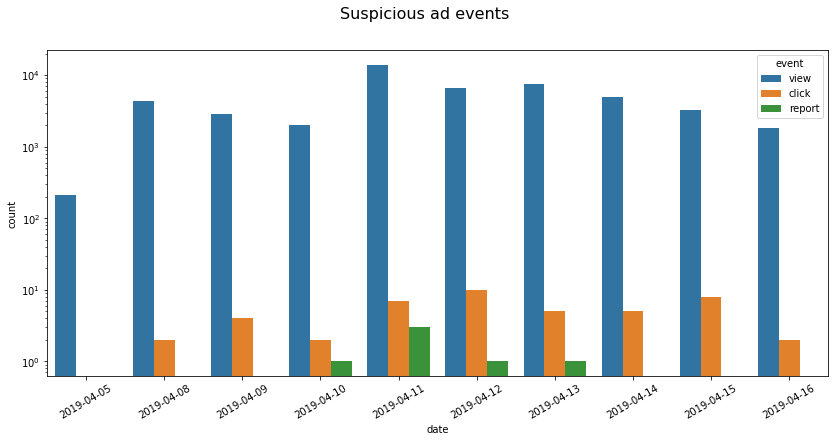

In [24]:
suspicious_ad_df = df.query("(campaign_union_id == @ad_campaign_prevalence.index[0])").sort_values('date')

fig, ax = plt.subplots(1, 1, figsize = (14, 6))
fig.suptitle('Suspicious ad events', fontsize=16) 
sns.countplot(x='date', hue='event', data=suspicious_ad_df)
ax.set_yscale('log')
for tick in ax.get_xticklabels(): 
    tick.set_rotation(30)

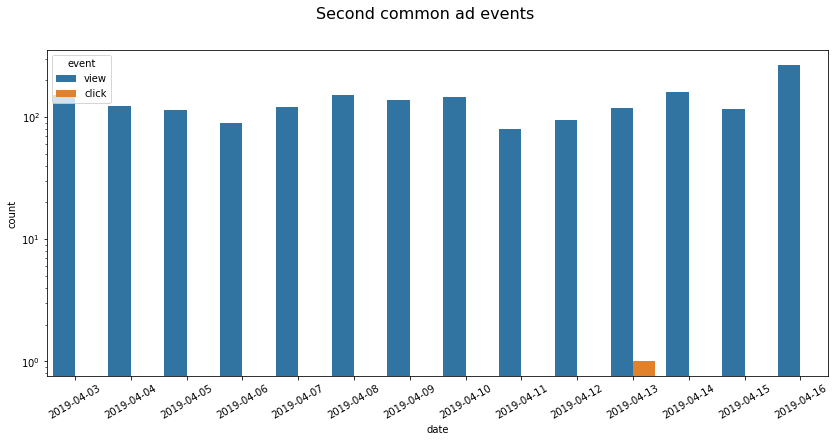

In [25]:
second_common_ad = df.query("campaign_union_id == @ad_campaign_prevalence.index[1]").sort_values('date')

fig, ax = plt.subplots(1, 1, figsize = (14, 6))
fig.suptitle('Second common ad events', fontsize=16) 
sns.countplot(x='date', hue='event', data=second_common_ad)
ax.set_yscale('log')
for tick in ax.get_xticklabels(): 
    tick.set_rotation(30)

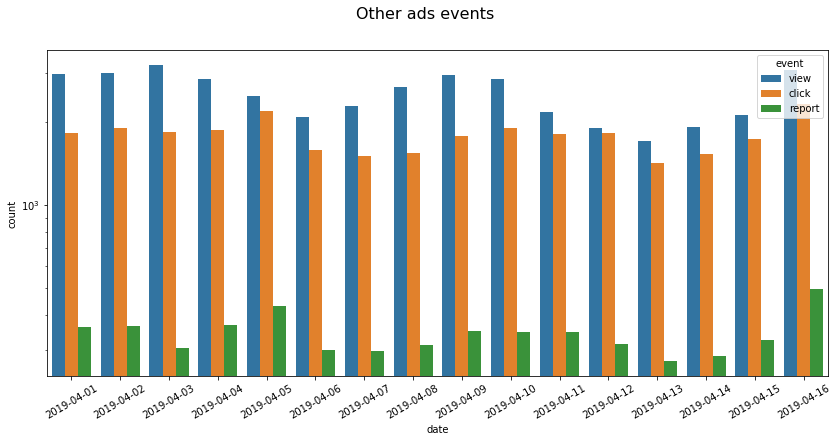

In [26]:
other_ads_df = df.query("campaign_union_id != @ad_campaign_prevalence.index[0]").sort_values('date')

fig, ax = plt.subplots(1, 1, figsize = (14, 6))
fig.suptitle('Other ads events', fontsize=16)
sns.countplot(x='date', hue='event', data=other_ads_df)
ax.set_yscale('log')
for tick in ax.get_xticklabels(): 
    tick.set_rotation(30)

**Заметим, что вообще говоря, в датафрейме содержится много событий о кликах. Проверим, а нет ли реклам, где кликов больше просмотров**

In [27]:
click_df = df.query("event == 'click'")
ad_campaign_popularity = click_df['campaign_union_id'].value_counts().to_frame().rename(columns={'campaign_union_id':'count'})
ad_campaign_popularity[:5]

,count
campaign_24261,534
campaign_21831,397
campaign_29021,283
campaign_18849,272
campaign_21405,267


In [28]:
df.query("campaign_union_id == @ad_campaign_popularity.index[0]").event.value_counts()

click     534
report    116
Name: event, dtype: int64

**У самой "популярной" (самой нажимаемой) рекламы вообще нет логов о просмотрах. Странно.**

In [29]:
n = len(ad_campaign_popularity)
i = 1
while (i < n and 
       'view' not in df.query("campaign_union_id == @ad_campaign_popularity.index[@i]").event.unique()): i += 1

print(f'First {i} from {n} ad campaigns do NOT have "view" event logs!')

First 51 from 8782 ad campaigns do NOT have "view" event logs!


In [30]:
ad_campaigns_viewed = set(df.query("event == 'view'").campaign_union_id.unique())
print(f'Num of unique viewed ad campaigns: {len(ad_campaigns_viewed)}')

ad_campaigns_clicked = set(df.query("event == 'click'").campaign_union_id.unique())
print(f'Num of unique clicked ad campaigns: {len(ad_campaigns_clicked)}')

strange_ad_campaigns = ad_campaigns_clicked - ad_campaigns_viewed
print(f'Num of strange clicked ad campaigns with no views: {len(strange_ad_campaigns)}')

Num of unique viewed ad campaigns: 2688
Num of unique clicked ad campaigns: 8782
Num of strange clicked ad campaigns with no views: 8689


**Очень странно, согласно датафрейму, на рекламу более 8 тысяч кампаний кликали, но не просматривали!**

**Проверим, какую долю об общего количества событий они занимают и в какие дни происходили:**

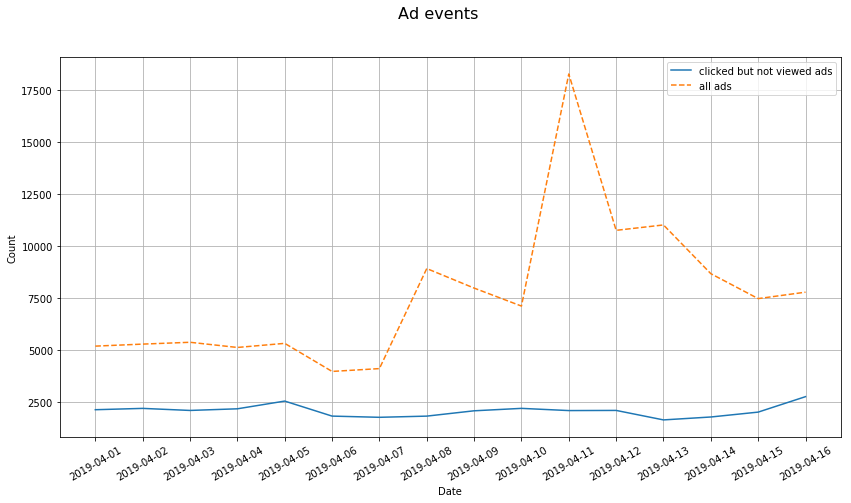

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))
fig.suptitle('Ad events', fontsize=16) 
plt.plot(df[df.campaign_union_id.isin(strange_ad_campaigns)].groupby('date').event.count())
plt.plot(df.groupby('date').event.count(), '--')
plt.legend(['clicked but not viewed ads', 'all ads'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.grid()



**События, связанные с такими странными кампаниями, случались каждый день без каких-то четких всплесков.**

**Подытоживая всё выше указанное: если бы я помогал аналитику, я бы ответил, что всплеск 11 апреля связан с одной определенной рекламной кампанией определенного клиента, и необходимо проверить, не происходило ли чего в это время с клиентом (выпуск новой продукции, хайповое событие и другие инфоповоды).**

**Также я бы обратил внимание, что около 2500 событий каждый день связанны с рекламами, которые согласно логам не просматриваются, но каким-то образом кликаются. С причинами этого нужно разобраться (возможно, ошибка в логировании событий).**

**Для детектирования аномалий предлагаю для каждой уникальной рекламной кампании `campaign_union_id`:**
- находить отношение количества уникальных значений в колонке `time` и общее количество событий (если значение ниже некого эмпирического параметра `A` $\in$ (0, 1], то, возможно, события дублируются)

- находить среднеквадратическое отклонение значений в колонке `time` (если общее количество событий больше эмпирического параметра `B`, а их разброс ниже эмпирического параметра `С`, то, возможно, это свидетельствует об атаке ботоводов)
 
- сравнивать количество событий `view` и `click` (первых должно быть не меньше вторых, иначе была потеряна информация о просмотрах или продублирована информация о кликах)

In [32]:
A = 0.8
B = 100
C = 1000
check_date = '2019-04-08'

check_date_df = df.query("date == @check_date")
check_date_df.event = check_date_df.event.replace({'report':0, 'view':0, 'click':1})
campaigns_df = check_date_df.groupby('campaign_union_id').\
    agg({'time':['count', 'nunique', 'std'], 'event': 'mean'})
campaigns_df['uniq_coef'] = campaigns_df['time']['nunique'] / campaigns_df['time']['count']

In [33]:
# первые 5 аномалий
campaigns_df.loc[((campaigns_df['uniq_coef'] < A) 
                  | ((campaigns_df['time']['count'] > B) & (campaigns_df['time']['std'] < C)) 
                  | (campaigns_df['event']['mean'] > 0.5)
                 )].head()

time             event uniq_coef
                  count nunique std  mean          
campaign_union_id                                  
campaign_10098        1       1 NaN   1.0       1.0
campaign_10103        1       1 NaN   1.0       1.0
campaign_101832       1       1 NaN   1.0       1.0
campaign_103780       1       1 NaN   1.0       1.0
campaign_104587       1       1 NaN   1.0       1.0